# Set Up and Data Processing

In [1]:
from capstone import data, uonesetup
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = Config.data_path()
# path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [3]:
# take 15% of data with a different seed
train_df, valid_df = data.data_processing(path, 'Atelectasis', 10, 0.15);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(34193, 2)

Validation shape
(234, 2)


In [4]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00002/study2/...,-1.0
1,CheXpert-v1.0-small/train/patient00002/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.0
3,CheXpert-v1.0-small/train/patient00010/study1/...,0.0
4,CheXpert-v1.0-small/train/patient00010/study1/...,0.0


In [5]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


## Further Training of Atelectasis Model
### Utilizing U-Ones Uncertainty Model

In [8]:
train_df['Atelectasis'].value_counts(normalize=True)

 0.0    0.698886
-1.0    0.155617
 1.0    0.145498
Name: Atelectasis, dtype: float64

In [9]:
valid_df['Atelectasis'].value_counts(normalize=True)

0.0    0.65812
1.0    0.34188
Name: Atelectasis, dtype: float64

In [10]:
# reassign -1 to 1 
train_df = train_df.replace(to_replace=-1.0, value=1)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [11]:
train_df['Atelectasis'].value_counts(normalize=True)

0    0.698886
1    0.301114
Name: Atelectasis, dtype: float64

In [12]:
train_df.shape

(34193, 2)

## DL Model Training

In [18]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}

auc = AUC()

In [13]:
tfms = get_transforms(True, False, max_rotate=None, max_zoom=0., max_lighting=0.3,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

In [14]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [15]:
src = src.split_by_rand_pct(0.1)

In [17]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7601MB of GPU RAM free


In [19]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [20]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc])

In [22]:
# load weights from stage 3 dn121 model for atelectasis
learn.load('atelectasis-stage-3-dn121');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


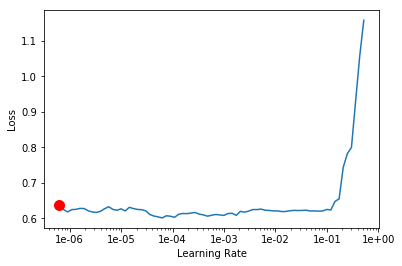

In [23]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04


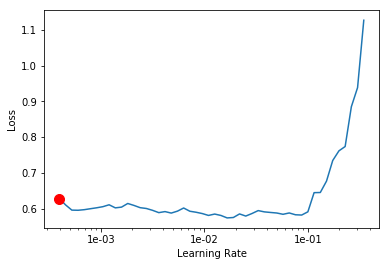

In [26]:
learn.lr_find(start_lr=1e-4, end_lr=100)
learn.recorder.plot(suggestion=True)

In [28]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.595693,0.596413,0.689383,0.632467,06:48
1,0.587080,0.594850,0.689383,0.630652,06:37


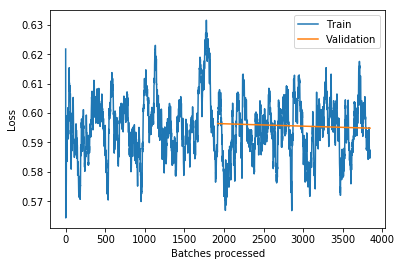

In [31]:
learn.recorder.plot_losses()

# Resize images to 320

In [29]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [30]:
learn.data = data # replace original data in learner with new data of size=320
data.train_ds[0][0].shape

torch.Size([3, 320, 320])

In [33]:
# standard learning rate from CheXpert paper
lr = 1e-4

In [34]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.593360,0.595532,0.689383,0.632224,11:52
1,0.625250,0.597963,0.689383,0.632093,11:42


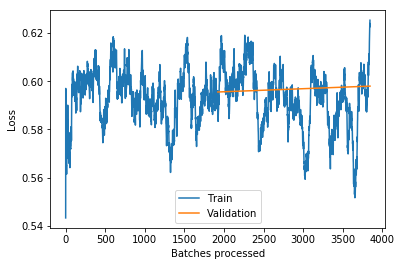

In [36]:
learn.recorder.plot_losses()

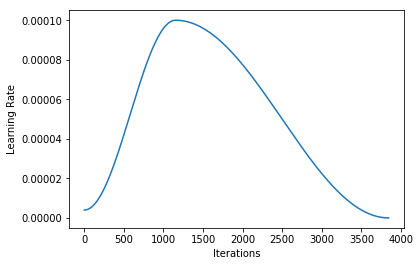

In [35]:
learn.recorder.plot_lr()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


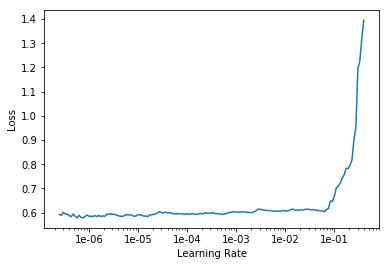

In [37]:
learn.lr_find(num_it=200)
learn.recorder.plot()

In [63]:
learn.save('atelectasis-stage-4-dn121')

# Reset Learner

In [52]:
tfms = get_transforms(True, False, max_rotate=None, max_zoom=0.,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

In [53]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [58]:
learner2 = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc], pretrained=True,
                      callback_fns=ShowGraph)

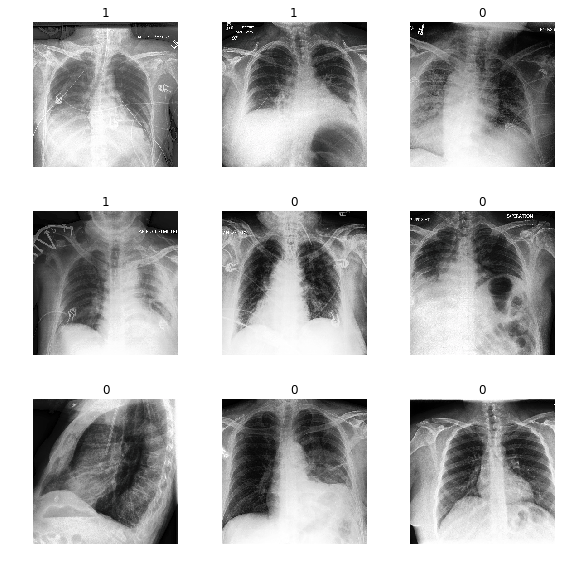

In [55]:
data.show_batch(rows=3, figsize=(8, 8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-06


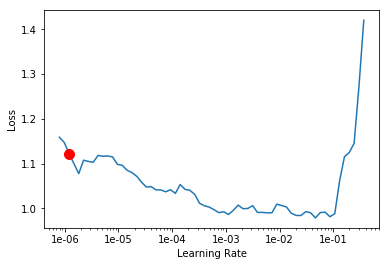

In [62]:
learner2.lr_find(start_lr=1e-7, end_lr=100)
learner2.recorder.plot(suggestion=True)

In [ ]:
learner2.fit_one_cycle()